In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from torch.utils.tensorboard import SummaryWriter
 
 
N_CLASSES = 91
FINAL_GRID_SIZE = 9
N_ANCHORS = 1
LAST_KERNEL_DIM = N_CLASSES+N_ANCHORS*5
SCALED_IMG_WIDTH = 288
SCALED_IMG_HEIGHT = 288
 
path2data="./COCO/imgs/train2017"
path2json="./COCO/jsons/annotations/instances_train2017.json"
writer = SummaryWriter('tb/yolo_with_backbone')
 
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

In [ ]:
! mkdir pretrained_models

In [ ]:
! wget http://images.cocodataset.org/zips/train2017.zip

In [ ]:
! zipsplit -n 3500000000 train2017.zip

In [ ]:
! unzip annotations_trainval2017.zip -d COCO


Archive:  annotations_trainval2017.zip
  inflating: COCO/annotations/instances_train2017.json  
  inflating: COCO/annotations/instances_val2017.json  
  inflating: COCO/annotations/captions_train2017.json  
  inflating: COCO/annotations/captions_val2017.json  
  inflating: COCO/annotations/person_keypoints_train2017.json  
  inflating: COCO/annotations/person_keypoints_val2017.json  


In [ ]:
! wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip


--2020-12-17 16:12:49--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.33.180
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.33.180|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  16.9MB/s    in 16s     

2020-12-17 16:13:05 (15.4 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [ ]:
! unzip train2_6.zip -d COCO
! rm train2_6.zip

In [2]:
transform = transforms.Compose([
        transforms.Resize((SCALED_IMG_HEIGHT, SCALED_IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform2view = transforms.Compose([
    transforms.Resize((SCALED_IMG_HEIGHT, SCALED_IMG_WIDTH)),
    transforms.ColorJitter(),
    transforms.RandomGrayscale(p=0.15),
    transforms.ToTensor(),
    transforms.RandomErasing(scale=(0.02, 0.10), value='random'),
    transforms.ToPILImage()
])
transform_augmentation = transforms.Compose([
    transforms.RandomGrayscale(p=0.15),
    transform,
    transforms.ColorJitter(),
    transforms.RandomErasing(scale=(0.02, 0.10), value='random')
])

In [3]:
def save(name, major, minor):
    YOLO_PATH = 'pretrained_models/yolo' +name+'_'+str(major)+'_'+str(minor)+'.th'
    OPT_PATH  = 'pretrained_models/opt' +name+'_'+str(major)+'_'+str(minor)+'.th'
    torch.save(yolo.state_dict(), YOLO_PATH)
    torch.save(opt.state_dict(),   OPT_PATH+name+'_'+str(major)+'_'+str(minor)+'.th')
def load(name, major, minor, opt_bool=True):
    YOLO_PATH = 'pretrained_models/yolo' +name+'_'+str(major)+'_'+str(minor)+'.th'
    OPT_PATH  = 'pretrained_models/opt' +name+'_'+str(major)+'_'+str(minor)+'.th'
    yolo.load_state_dict(torch.load(YOLO_PATH))
    # yolo.eval()
    if opt_bool:
        opt.load_state_dict(torch.load(OPT_PATH))

In [4]:
def draw_bounding_box(
    tensor,
    bboxes,
    strings,
    color=None,
    width=1,
    font_size=None
):

    from PIL import Image, ImageDraw, ImageFont
    ndarr = tensor.mul(255).add_(0.5).clamp_(0, 255).permute(
        1, 2, 0).to('cpu', torch.uint8).numpy()
    im = Image.fromarray(ndarr)
    draw = ImageDraw.Draw(im)
    img_h = tensor.shape[1]
    img_w = tensor.shape[2]
    if font_size is None:
        print(tensor.shape)
        font_size = int(25/600*img_h)
    font = ImageFont.truetype("font.otf", font_size)

    if color is None:
        all_colors = [(i*255, j*255, k*255) for i in range(2) for j in range(2) for k in range(2)]
        colors = random.choices(all_colors, k=len(bboxes))
    elif len(color) == 3 and isinstance(color[0], int):
        colors = [color]*len(bboxes)
    else:
        colors = color

    for bbox, color, string in zip(bboxes, colors, strings):
        # bbox = list(bbox)
        # bbox[0] = bbox[0] if bbox[0]>0 else 0
        # bbox[1] = bbox[1] if bbox[1]>0 else 0
        # bbox[2] = bbox[2] if bbox[2]<img_w else img_w
        # bbox[0] = bbox[3] if bbox[3]<img_h else img_h
        # bbox = tuple(bbox)
        textbox_width = int(font_size*len(string)*20/25)
        textbox_height = font_size+3
        y2 = bbox[1]-textbox_height
        if y2 < 0:
            y2 = bbox[1]+textbox_height
        fillbbox = [bbox[0], bbox[1], bbox[0]+textbox_width, y2]
        textbox = (bbox[0], min(bbox[1], y2))
        textcolor = tuple(255-c for c in color)  

        draw.rectangle(bbox, outline=color, width=width)
        draw.rectangle(fillbbox, fill=color, width=width)
        draw.text(textbox, string, fill=textcolor, font=font)

    from numpy import array as to_numpy_array
    return torch.from_numpy(to_numpy_array(im))

def visualize_img(img, annotation, color=None, width=3):
    img = transforms.ToTensor()(img)
    bboxes = []
    strings = []
    for ann in annotation:
        ann2 = ann['bbox']
        ann2 = ann2[0], ann2[1], ann2[0]+ann2[2], ann2[1]+ann2[3]
        bboxes.append(ann2)
        strings.append(cats[ann['category_id']])
        # print(strings[-1], ann['category_id'], type(cats[ann['category_id']]), cats[ann['category_id']])


    img = draw_bounding_box(img, bboxes, strings, color=None, width=width)
    plt.imshow(img.numpy())


In [5]:
def transform_f (img, annotations, train=True, size=(SCALED_IMG_HEIGHT, SCALED_IMG_WIDTH)):
    if train:
        transform = transform_augmentation
    else:
        transform = transform2view
    w, h = img.size[1], img.size[0]
    scalex = size[1]/w
    scaley = size[0]/h
    if scalex == 1:
        print("eq")
    import copy 
    annotations = copy.deepcopy(annotations)
    for i, ann in enumerate(annotations):
        a = ann['bbox']
        a = (a[0]*scaley, a[1]*scalex, a[2]*scaley, a[3]*scalex)
        annotations[i]['bbox'] = a
    img = transform(img)
    return img, annotations

In [6]:
def batching_func(l):
    import math
    imgs = [x[0].unsqueeze(0) for x in l]
    imgs = torch.cat(imgs, dim=0)
    w, h = imgs.shape[-2], imgs.shape[-1]
    idiv = h/FINAL_GRID_SIZE
    jdiv = w/FINAL_GRID_SIZE
    target = torch.zeros(len(imgs), LAST_KERNEL_DIM, FINAL_GRID_SIZE, FINAL_GRID_SIZE)
    class_ids     = torch.zeros(len(imgs), N_CLASSES,   FINAL_GRID_SIZE, FINAL_GRID_SIZE)
    objectness    = torch.zeros(len(imgs), N_ANCHORS,   FINAL_GRID_SIZE, FINAL_GRID_SIZE)
    offsets       = torch.zeros(len(imgs), N_ANCHORS*2, FINAL_GRID_SIZE, FINAL_GRID_SIZE)
    normalized_wh = torch.zeros(len(imgs), N_ANCHORS*2, FINAL_GRID_SIZE, FINAL_GRID_SIZE)
    lasti = 0

    annotations = [x[1] for x in l]
    for el, annotation in enumerate(annotations):
        for ann in annotation:
            bbox = ann['bbox']
            class_id = ann['category_id']
            celli = (bbox[0]+bbox[2])/2/idiv
            cellj = (bbox[1]+bbox[3])/2/jdiv
            i = int(celli)
            j = int(cellj)
            offset_i = celli - i
            offset_j = cellj - j
            normalized_w = math.sqrt(bbox[2]/w)
            normalized_h = math.sqrt(bbox[3]/h)

            class_ids[el, class_id, i, j] = 1
            objectness[el, lasti, i, j] = 1
            offsets[el, lasti*2:(lasti+1)*2, i, j] = torch.tensor([offset_i, offset_j], dtype=torch.float)
            normalized_wh[el, lasti*2:(lasti+1)*2, i, j] = torch.tensor([normalized_w, normalized_h], dtype=torch.float)
            lasti = (lasti+1)%N_ANCHORS
            # print(celli, cellj)
    return imgs, (class_ids, objectness, offsets, normalized_wh)

In [7]:
coco_train = dset.CocoDetection(root = path2data,
                                annFile = path2json,
                                transforms=transform_f)

cats = coco_train.coco.loadCats(coco_train.coco.getCatIds())
cats2 = []
for cat in cats:
    while cat['id'] != len(cats2):
        cats2.append('None')
    cats2.append(cat['name'])
cats = cats2

loading annotations into memory...
Done (t=17.56s)
creating index...
index created!


torch.Size([3, 426, 640])


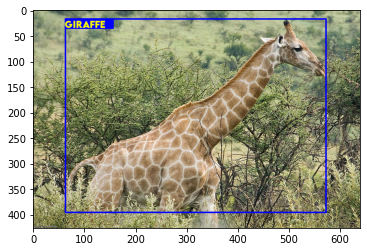

In [8]:
import random
import torch
ii = random.randint(0, 10000)
coco_train.transforms = None
img, ann = coco_train[ii]
coco_train.transforms = transform_f
visualize_img(img, ann)

torch.Size([3, 288, 288])


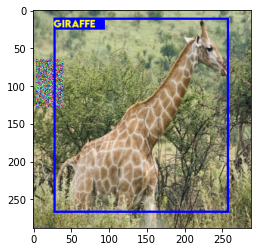

In [9]:
ten, ann = transform_f(img, ann)
img = transform2view(img)
visualize_img(img, ann)

In [69]:
data_loader = torch.utils.data.DataLoader(coco_train,
                                          batch_size=2,
                                          shuffle=True,
                                          num_workers=4,
                                          collate_fn=batching_func
                                        )

In [10]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.zero_pad = nn.ZeroPad2d(1)
        self.conv = nn.Conv2d(kernel_size=3, in_channels=in_channels, out_channels=out_channels, stride=stride)
        self.bnorm = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        x = self.zero_pad(x)
        x = self.conv(x)
        x = self.bnorm(x)
        x = F.relu(x)
        return x

class Yolo(nn.Module):
    def __init__(self, conv_list, nc_last_conv, device):
        super().__init__()
        self.conv_list = conv_list
        self.conv_layers = []
        self.last_conv = nn.Conv2d(kernel_size=1, in_channels=conv_list[-1][0], out_channels=nc_last_conv, stride=1)
        for (in_channels, _), (out_channels, stride) in zip(conv_list[:-1], conv_list[1:]):
            self.conv_layers.append(ConvLayer(in_channels, out_channels, stride).to(device))
        self.default_anchor_size = 0.3

    def forward(self, x, separate=True):
        for layer, (inc, _), (outc, stride) in zip(self.conv_layers, conv_list[:-1], conv_list[1:]):
            skip = x
            x = layer(x)
            # print(x.shape)
            if inc==outc and stride==1:
                x += skip
        
        # print(x.shape)
        x = self.last_conv(x)
        # print(x.shape)

        class_preds = x[:, :91,   :, :]
        objectness  = x[:, 91,    :, :].unsqueeze(1)
        offsets     = x[:, 92:94, :, :]
        boxes       = x[:, 94:96,   :, :]

        objectness  = th.sigmoid(objectness)
        boxes       = th.exp(boxes) * self.default_anchor_size
        offsets     = th.sigmoid(offsets) 
        class_preds = th.sigmoid(class_preds)
        # print("-"*10)
        if separate:
            return class_preds, objectness, offsets, boxes
        return torch.cat((class_preds, objectness, offsets, boxes), dim=1)

class Detector(nn.Module):
    def __init__(self, conv_list, device):
        super().__init__()
        self.backbone = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True).features.to(device)
        #self.backbone.eval()
        #for p in self.backbone:
        #    p.requires_grad = False
        self.head = Yolo(conv_list, LAST_KERNEL_DIM, device=device).to(device)
    def forward(self, x):
        features = self.backbone(x)
        return self.head(features)

# out_channels, stride
conv_list = [
    [3, 1], #dummy begin
    [32, 2],
    [32, 1],
    [64, 2],
    [64, 1],
    [64, 1],
    [128, 2],
    [128, 1],
    [128, 1],
    [512, 2],
    [512, 1],
    [512, 1],
    [1024, 2],
    [1024, 1],
    [1024, 1],
]
conv_list_mobile = [
    [1280, 1], #dummy begin
    [1024, 1],
    [1024, 1]
]

try:
    del yolo
except:
    pass
# yolo = Yolo(conv_list, LAST_KERNEL_DIM, device=device).to(device)
yolo = Detector(conv_list_mobile, device)

Using cache found in /home/darijan/.cache/torch/hub/pytorch_vision_v0.6.0


In [11]:
opt = th.optim.Adam([
    {'params':yolo.backbone.parameters(), 'lr':1e-4},
    {'params':yolo.head.parameters()}
])

In [72]:
del class_ids, objectness, offsets, normalized_wh
del preds_class_ids, preds_objectness, preds_offsets, preds_normalized_wh

NameError: name 'preds_class_ids' is not defined

In [70]:
def bce(targets, preds, lmbda, indicator=None, numsc = 1e-8):
    t1 =  -(lmbda*targets*th.log(preds+numsc) + (1-targets)*th.log(1-preds+numsc))
    if indicator is None:
        return t1.mean()
    # print(t1.shape, indicator.shape, (t1*indicator).shape)
    return (t1*indicator).sum()/indicator.sum()

eps = 100
numsc = 1e-9
i_mbatch = 0
for ep in range(eps):
    for i_mbatch2, (imgs, targets) in enumerate(data_loader):
        i_mbatch += 1
        class_ids, objectness, offsets, normalized_wh = targets
        class_ids, objectness, offsets, normalized_wh = class_ids.to(device), objectness.to(device), offsets.to(device), normalized_wh.to(device)
        preds_class_ids, preds_objectness, preds_offsets, preds_normalized_wh = yolo(imgs.to(device))
        
        indicator = class_ids.sum(dim=1).unsqueeze(1) > 0.5
        loss_c   = bce(class_ids, preds_class_ids, 1, indicator)
        loss_obj = bce(objectness, preds_objectness, 20)/20
        loss_off = bce(offsets, preds_offsets, 1, indicator)
        loss_wh  = (((normalized_wh-preds_normalized_wh)**2) *indicator).sum()/indicator.sum()
        
        loss = loss_c/10 + loss_obj*10 + loss_off/3 + loss_wh*10
        opt.zero_grad()
        loss.backward()
        opt.step()

        if i_mbatch%5==0:
            print(ep, i_mbatch, loss_c.item()/10, loss_obj.item()*10, loss_off.item()/3, loss_wh.item()*10, loss.item())
        if i_mbatch % 750==0:
            save('with_backbone_', ep+1, i_mbatch)

        step = int(ep*120000/64 + i_mbatch)
        writer.add_scalar('loss/class', loss_c, step)
        writer.add_scalar('loss/object', loss_obj, step)
        writer.add_scalar('loss/offset', loss_off, step)
        writer.add_scalar('loss/bbox_wh', loss_wh, step)



RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 1.96 GiB total capacity; 1019.81 MiB already allocated; 7.75 MiB free; 1.02 GiB reserved in total by PyTorch)

In [ ]:
save('with_backbone_', ep, i_mbatch)

In [12]:
load('with_backbone_', 2, 22500, 1)
# del yolo

torch.Size([3, 480, 640])


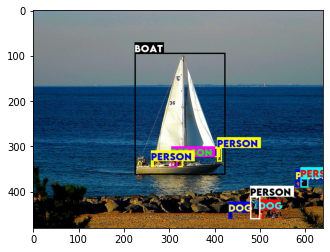

In [44]:
import random
import torch
ii = random.randint(0, 10000)
coco_train.transforms = None
img, ann = coco_train[ii]
coco_train.transforms = transform_f
visualize_img(img, ann)

In [45]:
yolo.backbone.train()
yolo.head.train()

Yolo(
  (last_conv): Conv2d(1024, 96, kernel_size=(1, 1), stride=(1, 1))
)

torch.Size([9, 9]) tensor(0.0409, device='cuda:0', grad_fn=<MaxBackward1>)
0
<class 'PIL.Image.Image'> <class 'list'>
torch.Size([3, 288, 288])
0


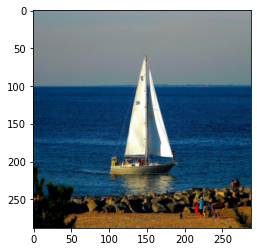

In [46]:
tens, ann = transform_f(img, ann)
imgs, _ = batching_func([[tens, ann]])
# yolo.eval()
preds_class_ids, preds_objectness, preds_offsets, preds_normalized_wh = yolo(imgs.to(device))
# print(preds_objectness.shape, len(imgs))
objectness = preds_objectness.squeeze(0).squeeze(0)
class_id   = th.argmax(preds_class_ids, dim=1).squeeze(0)
class_prob = th.max(preds_class_ids, dim=1)[0].squeeze(0)
prob = objectness*class_prob   
# prob = objectness  / torch.max(objectness)
print(prob.shape, torch.max(objectness))
# prob = class_prob   
# class_ids, objectness, offsets, normalized_wh = class_ids.to(device), objectness.to(device), offsets.to(device), normalized_wh.to(device)

yolo_ann = []
thres = 0.2
annotations = []
for i in range(FINAL_GRID_SIZE):
    for j in range(FINAL_GRID_SIZE):
        if prob[i, j].item() > thres:
            centy = (i+preds_offsets[0, 0, i, j]).item()*SCALED_IMG_HEIGHT/FINAL_GRID_SIZE
            centx = (j+preds_offsets[0, 1, i, j]).item()*SCALED_IMG_WIDTH /FINAL_GRID_SIZE
            width = th.square(preds_normalized_wh[0, 0, i, j]).item() * SCALED_IMG_WIDTH
            height= th.square(preds_normalized_wh[0, 1, i, j]).item() * SCALED_IMG_HEIGHT
            # width = height = 30
            top_left_x = centx-width/2
            top_left_y = centy-height/2
            bbox = [top_left_x, top_left_y, width, height]
            category_id = int(class_id[i, j].item())
            ann_tmp = {'bbox':bbox, 'category_id':category_id}
            # dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])
            annotations.append(ann_tmp)
            


print(len(annotations))
            
offsets    = preds_offsets.squeeze(0)
del preds_class_ids, preds_objectness, preds_offsets, preds_normalized_wh
small_img = transforms.Resize((SCALED_IMG_WIDTH, SCALED_IMG_WIDTH))(img)
print(type(small_img), type(annotations))
visualize_img(small_img, annotations)
print(len(annotations))
for ann in annotations:
    print(cats[ann['category_id']])

tensor([[ 1, 44, 37, 16, 16,  1, 16, 15,  1],
        [ 1,  1,  1,  1,  1,  1, 62, 64,  1],
        [ 3,  1,  1,  1,  1,  1, 62,  3,  1],
        [ 1,  1,  1,  1,  1,  1,  1,  3,  1],
        [ 1,  1,  1,  1,  1,  1,  1,  3,  1],
        [15,  1,  1,  1,  1,  1,  1,  3,  1],
        [85,  1,  1,  1,  1,  1, 27,  1,  1],
        [85,  1,  1,  3,  3,  1,  1,  1,  1],
        [44,  3, 16,  1,  3,  3,  1,  1,  1]], device='cuda:0')

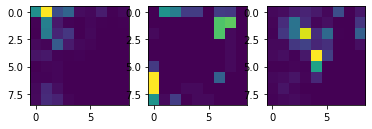

In [47]:
plt.subplot(1, 3, 1)
plt.imshow(prob.cpu().detach().numpy())
plt.subplot(1, 3, 2)
plt.imshow(class_id.cpu().detach().numpy())
plt.subplot(1, 3, 3)
plt.imshow(class_prob.cpu().detach().numpy())
class_id

In [48]:
prob

tensor([[5.9138e-05, 1.1863e-04, 2.8160e-05, 3.8428e-05, 3.8876e-06, 2.7698e-06,
         9.1370e-06, 7.4519e-07, 2.7404e-06],
        [7.0221e-07, 5.1558e-05, 7.9340e-06, 1.3526e-06, 8.5024e-08, 1.9586e-06,
         4.8613e-07, 9.9062e-10, 5.7985e-07],
        [1.9335e-07, 4.9534e-05, 1.2337e-05, 1.8838e-05, 2.9779e-07, 2.6196e-06,
         1.0940e-07, 1.0656e-12, 1.9576e-08],
        [3.0503e-06, 1.4688e-06, 3.3966e-05, 8.6294e-06, 2.7015e-06, 1.4148e-06,
         1.7571e-09, 1.8036e-14, 4.0644e-11],
        [6.3459e-06, 7.4340e-06, 1.1077e-06, 5.8114e-07, 9.4663e-07, 4.0296e-08,
         1.6224e-12, 1.9948e-15, 3.2733e-15],
        [1.6702e-07, 1.4311e-06, 2.0912e-06, 2.5122e-07, 5.2458e-08, 1.3657e-13,
         2.0247e-16, 1.5686e-23, 2.3524e-17],
        [9.7500e-07, 1.0644e-06, 1.8922e-06, 2.7111e-08, 5.4887e-10, 4.1886e-14,
         8.3348e-22, 1.0128e-23, 3.6357e-17],
        [2.5467e-06, 1.3538e-05, 4.3290e-06, 2.7526e-07, 1.4104e-10, 1.2656e-16,
         5.4935e-17, 1.5480e-2

In [88]:
def IoU(bbox1, bbox2):
    x11, y11 = bbox1[0], bbox1[1]
    x12, y12 = x11+bbox1[2], y11+bbox1[3]
    x21, y21 = bbox2[0], bbox2[1]
    x22, y22 = x21+bbox2[2], y21+bbox2[3]

    xtop, ytop = max(x11, x21), max(y11, y21)
    xbot, ybot = min(x12, x22), min(y12, y22)


    if xtop<xbot and ytop<ybot:
        intersection = (xbot-xtop)*(ybot-ytop)
    else:
        intersection = 0
    area1 = bbox1[2]*bbox1[3]
    area2 = bbox2[2]*bbox2[3]
    union = area1 + area2 - intersection
    # print(x11, y11, x12, y12)
    # print(x21, y21, x22, y22)
    # print(intersection, area1, area2, union)

    return intersection/union

def non_max_supression(confidence, annotation, thres):
    for i1, (con1, ann1) in zip(confidence, annotation):
        for i2, (con2, ann2) in zip(confidence, annotation):
            pass


In [89]:
l = 1
a = 4

def nesto():
    l = 3
    print(a)

In [90]:
nesto()

4


In [95]:
IoU([5, 5, 10, 10], [0, 0, 10, 10])

0.1282051282051282